# Image deblurring with Conjugate Gradient and FFT

In [40]:
from PIL import Image
import numpy as np
import matplotlib.pyplot as plt
import time

Implementation of a sinc PSF, defined by
$$
f_{i,j}=c(\sigma + sin(\alpha (i^2+j^2)^{1/2})),
$$
where $i,j\in \{0,...,2k+1\}$ determine the size of the blur, $\alpha$ determines the intensity of the blur, $\sigma$ is chosen in order to have non-negative values of the PSF, and the value $c$ is chosen so that the elements of the PSF sum to $1$.

In [41]:
def psf_sinc(k, alfa):
    """
    Create an exponential Point Spread Function (PSF) of size (2k+1)x(2k+1)
    with elements sinc(alfa*(i^2+j^2)^0.5), where i, j = -k, k.
    
    Parameters:
        k (int): Half the size of the PSF in each dimension.
        alfa (float): Parameter for adjusting the sinc function.
    
    Returns:
        numpy.ndarray: The created PSF.
    """
    x = np.arange(-k, k + 1).reshape(-1, 1) * np.ones((1, 2 * k + 1))
    y = x.transpose()
    psf = np.sinc(alfa * np.sqrt(x**2 + y**2))
    m = np.min(psf)
    psf = psf - m
    psf = psf / np.sum(psf)
    return np.double(psf)

Here is an example of a PSF of type $sinc$ with parameters $k=6$ and $\alpha = 0.4$

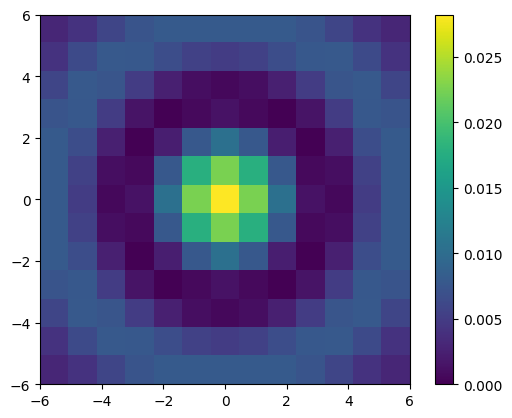

In [42]:
# Parameters
k = 6
alfa = 0.4

# Generate PSF
psf = psf_sinc(k, alfa)

# Plotting the PSF
plt.imshow(psf, cmap='viridis', origin='upper', extent=[-6, 6, -6, 6])
plt.colorbar()
plt.show()

These auxiliary functions manage the factors and prime components of a number, serving as building blocks for implementing the FFT.

In [43]:
def next_factor(n):
    """Return the smallest factor of n greater than 1 using precomputed small primes."""
    if n <= 1:
        raise ValueError("Input must be greater than 1")
    
    # Small prime numbers for initial checking
    small_primes = [2, 3, 5, 7, 11, 13, 17, 19, 23, 29, 31, 37, 41, 43]

    # Check against small primes less than max_factor
    max_factor = int(np.sqrt(n))
    
    # First check against precomputed small primes
    for prime in small_primes:
        if prime > max_factor:
            return n, 1
        if n % prime == 0:
            return prime, n // prime
    
    for prime in range(47, max_factor + 1, 2):
        if n % prime == 0:
            return prime, n // prime
    
    # If no factor is found, return n (which means n is prime)
    return n, 1


def is_prime(n):
    """Return the smallest factor of n greater than 1 using precomputed small primes."""
    if n <= 1:
        raise ValueError("Input must be greater than 1")
    
    # Small prime numbers for initial checking
    small_primes = [2, 3, 5, 7, 11, 13, 17, 19, 23, 29, 31, 37, 41, 43]

    # Check against small primes less than max_factor
    max_factor = int(np.sqrt(n))
    
    # First check against precomputed small primes
    for prime in small_primes:
        if prime > max_factor:
            return True
        if n % prime == 0:
            return False
    
    for prime in range(47, max_factor + 1, 2):
        if n % prime == 0:
            return False
    
    # If no factor is found n is prime
    return True


def prime_factors(n):
    """Finds prime factors of a given number n."""
    factors = set()
    
    # Small prime numbers for initial checking
    small_primes = [2, 3, 5, 7, 11, 13, 17, 19, 23, 29, 31, 37, 41, 43]
    
    # Calculate max factor
    max_factor = int(np.sqrt(n)) + 1
    
    # First check against precomputed small primes
    for prime in small_primes:
        if prime > max_factor:
            factors.add(n)
            n = 1
        while n % prime == 0:
            factors.add(prime)
            n //= prime
        if n == 1:
            return factors
    
    # Continue checking for factors beyond small primes
    for i in range(47, max_factor, 2):
        while n % i == 0:
            factors.add(i)
            n //= i
        if n == 1:
            return factors
    
    # If n is still greater than 1, it is prime and should be added to factors
    if n > 1:
        factors.add(n)
    
    return factors

Below there is an implementation of the Cooley-Tukey FFT algorithm. The implementation uses a divide and conquer approach, where a vector is divided in $p$ vectors of size $q$ until the vector size is prime. At that point, the following merging formula is applied:
$$
X(k_2,k_1) =  \sum_{j_1=0}^{n_1-1}\left[\sum_{j_2=0}^{n_2-1}x(j_1,j_2)\omega_{n_2}^{j_2k_2}\omega_{n_1n_2}^{j_1k_2}\right]\omega_{n_1}^{j_1k_1},
$$
where $n_1$,$n_2$ are such that the vector size $n=n_1n_2$, the vectors are defined as follows:
$$
x(j)=x(j_1,j_2)\text{,} \hspace{0.5cm} 0\leq j_1\leq n_1-1\text{,} \hspace{0.5cm} 0\leq j_2\leq n_2-1
$$
$$
X(k)=X(k_2,k_1)\text{,} \hspace{0.5cm} 0\leq k_1\leq n_1-1\text{,} \hspace{0.5cm} 0\leq k_2\leq n_2-1
$$
Finally, the indexes $j$ and $k$ are defined as:
$$
j=j_1+j_2n_1 \text{,} \hspace{0.5cm} k=k_2+k_1n_2.
$$
Instead, the IFFT can be computed straightforward by applying the following formula:
$$
\texttt{IFFT}(x)=\frac{\overline{\texttt{FFT}(\overline{x})}}{n}.
$$

In [44]:
def fft1d(x):
    """Mixed-radix Cooley-Tukey FFT"""
    N = len(x)
    if N <= 1:
        return x

    # Find a prime factor of N to split the array
    p, q = next_factor(N)
    
    # FFT of subarrays
    X_p = [fft1d(x[k::p]) for k in range(p)]
    
    # Precompute twiddle factors
    twiddle_factors = np.exp(-2j * np.pi * np.arange(N) / N)
    
    # Combine the results using in-place computation
    X = np.zeros(N, dtype=complex) 
    for k in range(N):
        for j in range(p):
            X[k] += X_p[j][k % q] * twiddle_factors[j * k % N]
    
    return X

def ifft1d(X): return np.conj(fft1d(np.conj(X)))/len(X)

The 2D-FFT is implemented by making use of the following formula:
$$
X(k_1,k_2) = \sum_{j_1=0}^{m-1}\left[\sum_{j_2=0}^{n-1}x(j_1,j_2)\omega_n^{j_2k_2}\right]\omega_m^{j_1k_1},
$$
the inverse is obtained analogously.

In [8]:
def fft2d(matrix):
    # Compute the 2D FFT using row-column decomposition
    # Apply 1D FFT to each row
    rows = np.array([fft1d(row) for row in matrix])
    
    # Apply 1D FFT to each column of the row-transformed matrix
    cols = np.array([fft1d(rows[:, j]) for j in range(rows.shape[1])]).T
    
    return cols

def ifft2d(matrix):
    # Compute the 2D IFFT using row-column decomposition
    # Apply 1D IFFT to each row
    rows = np.array([ifft1d(row) for row in matrix])
    
    # Apply 1D IFFT to each column of the row-transformed matrix
    cols = np.array([ifft1d(rows[:, j]) for j in range(rows.shape[1])]).T
    
    return cols

The following functions are used to compute the convolution using the FFT.

In [9]:
def my_fftpsf(psf, m, n):
    """
    Pad the PSF to the same size of a restored image. 
    Calculate the FFT of this zero-padded PSF matrix.
    """
    s = psf.shape
    a = np.zeros((m + s[0] - 1, n + s[1] - 1), dtype=psf.dtype)
    a[:s[0], :s[1]] = psf
    fpsf = fft2d(a)
    return fpsf

def my_fx(fpsf, x):
    """
    Compute the product y=Fx of the block-Toeplitz matrix F and a vector x.
    """
    M, N = fpsf.shape
    sx = x.shape
    xx = np.zeros((M, N  ), dtype=x.dtype)
    xx[:sx[0], :sx[1]] = x
    fx = fft2d(xx)
    y = ifft2d(fx * fpsf)
    return y

def my_ftx(fpsf, y, k):
    """
    Compute the product z = F^Ty of the transpose of the block-Toeplitz matrix F^T
    and a vector y.
    """
    w = fft2d(y)
    u = ifft2d(w * np.conj(fpsf))
    z = u[:-(2*k), :-(2*k)]  # Extracting the desired region
    return z


This implementation of the Conjugate Gradient method takes as input the blurred image, $\texttt{b}$, the Point Spread Function, $\texttt{psf}$, the number of iterations, $\texttt{steps}$, the regularization parameter, $\texttt{reg}$, and the error tolerance, $\texttt{epsilon}$. At each iteration, the function prints both the residual and the time taken to execute that step. After completing all iterations, it outputs the average time per cycle and returns the restored image, $\texttt{x}$.

In [45]:
def my_gc_reg_toeplitz(b, psf, steps, reg, epsilon):
    times = np.zeros(steps)
    # Define the point-spread function (psf)
    psft = psf[::-1, ::-1]
    z = psft.shape
    k = int((z[0] - 1)/2) # k is an integer
    
    # Define the dimensions of the objects
    s = b.shape
    
    # Initialize the iterations of GC
    if len(s) == 3:
        x = np.zeros((s[0]+2*k,s[1]+2*k,s[2]))
        coln = 3
    else:
        x = np.zeros((s[0]+2*k,s[1]+2*k))
        coln = 1
    
    # psf associated to F^T
    psft = my_fftpsf(psf,s[0],s[1])
    for col in range(coln):
        if coln == 3:
            r = b[:, :, col]
        else:
            r = b
        
        r = np.double(r)
        y = np.zeros((s[0], s[1]))
        for iter in range(steps):
            start_time = time.time()
            rho = np.sum(np.sum(r * r))
            if iter == 0:
                p = r
            else:
                beta = rho / rhop
                p = r + beta * p
            
            tmp = my_fx(psft,p)
            q = my_ftx(psft,tmp,k)
            q = q + reg * p
            alpha = rho / np.sum(np.sum(p * q))
            y = y + alpha * p
            r = r - alpha * q
            rhop = rho
            nor = np.abs(np.sqrt(np.sum(np.sum(r * r))) / (s[0] * s[1]))
            end_time = time.time()
            elapsed_time = end_time - start_time
            times[iter] = elapsed_time
            print("Elapsed time:", elapsed_time, "seconds")
            print(f'Channel {col+1}, step={iter+1}, residual={nor}')
            
            # Check convergence
            if nor < epsilon:
                print(f'Converged at step {iter+1} with residual {nor}')
                break
        
        if coln == 3:
            x[:, :, col] = np.real(my_fx(psft,y))
        else:
            x = np.real(my_fx(psft,y))
        
    x = np.clip(x,0,255).astype(np.uint8)
    print("Mean time per cycle:", np.mean(times), "seconds")
    
    return x

Given that the PSF is assumed to be known in the initial hypothesis, the image will be blurred using this known PSF. 

In [83]:
def blur(a, psf, k):
    """
    Deconvolves an image using the given Point Spread Function via FFT.
    """
    s = a.shape

    # Pad the PSF to the same size as the input image
    psf_padded = np.zeros((s[0],s[1]))
    psf_shape = psf.shape
    psf_padded[:psf_shape[0], :psf_shape[1]] = psf

    # Compute the FFT of the padded PSF
    psf_fft = np.fft.fft2(psf_padded)

    if len(s) == 3:
        b = np.zeros((s[0]-2*k, s[1]-2*k, 3), dtype=np.uint8)
        for i in range(s[2]):
            # FFT of the image channel
            a_fft = np.fft.fft2(a[:, :, i])
            
            # Convolution in frequency domain
            conv_result = np.fft.ifft2(a_fft * psf_fft)
            
            # Crop the result to the valid region 
            b[:, :, i] = np.real(conv_result[k:s[0]-k, k:s[1]-k])
            
    else:
        a_fft = np.fft.fft2(a)
        conv_result = np.fft.ifft2(a_fft * np.conj(psf_fft))
        b = np.real(conv_result[:s[0]-2*k, :s[1]-2*k])

    return np.clip(b,0,255).astype(np.uint8)

Analysis of a toy example, with a focus on a zoomed-in section to better visualize the restoration process after 5, 10, 15, and 20 steps. The image is zoomed in on the letter 'p,' as it effectively illustrates the restoration progress.

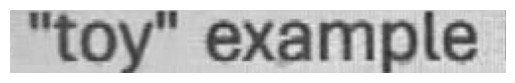

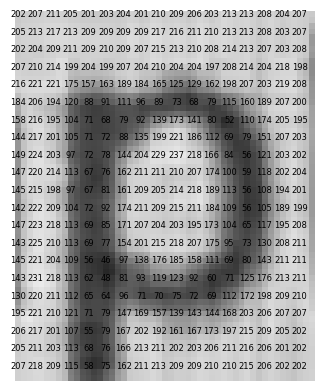

In [49]:
# Set blurring parameters
k = 9
alpha = 0.9
psf = psf_sinc(k,alpha)
reg = 0.01
tolerance = 0

# FILE PATH ON YOUR DEVICE FOR THE TOY EXAMPLE
file_path = 'toy_example.png'
# Sharp image
A = np.array(Image.open(file_path))
plt.imshow(A)
plt.axis('off')
plt.show()
a = A[:,362:413,0]
plt.imshow(a, cmap='gray', vmin=0, vmax=255)
plt.axis('off')
height, width = a.shape
for y in range(0, height, 3):
    for x in range(0, width, 3):
        plt.text(x, y, str(a[y, x]), color='black', fontsize=6, ha='center', va='center')

plt.show()

Visualisation of the blurred image

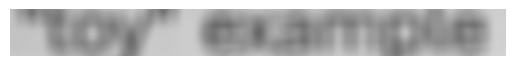

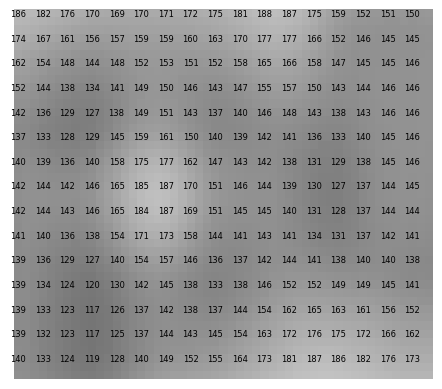

In [59]:
# Blurred image
b = blur(A[:,:,0],psf,k)
plt.imshow(b, cmap='gray', vmin=0, vmax=255)
plt.axis('off')
plt.show()
b1 = b[:,362:413]
plt.imshow(b1, cmap='gray', vmin=0, vmax=255)
plt.axis('off')
height, width = b1.shape
for y in range(0, height, 3):
    for x in range(0, width, 3):
        plt.text(x, y, str(b1[y, x]), color='black', fontsize=6, ha='center', va='center')

plt.show()

Visualisation of the restored image after 5 steps.

Elapsed time: 5.967333555221558 seconds
Channel 1, step=1, residual=0.2493073095703064
Elapsed time: 6.335809946060181 seconds
Channel 1, step=2, residual=0.13701542824805574
Elapsed time: 6.555008888244629 seconds
Channel 1, step=3, residual=0.16295689865285792
Elapsed time: 6.546288251876831 seconds
Channel 1, step=4, residual=0.07428289943852362
Elapsed time: 6.417816877365112 seconds
Channel 1, step=5, residual=0.048973927710447
Mean time per cycle: 6.364451503753662 seconds


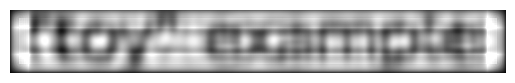

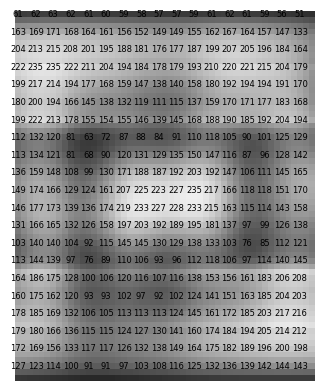

In [60]:
# Restored images
c = my_gc_reg_toeplitz(b,psf,5,reg,tolerance)
plt.imshow(c, cmap='gray', vmin=0, vmax=255)
plt.axis('off')
plt.show()

d = c[:,362:413]
plt.imshow(d, cmap='gray', vmin=0, vmax=255)
plt.axis('off')
height, width = d.shape
for y in range(0, height, 3):
    for x in range(0, width, 3):
        plt.text(x, y, str(d[y, x]), color='black', fontsize=6, ha='center', va='center')

plt.show()

Visualisation of the restored image after 10 steps.

Elapsed time: 6.0444419384002686 seconds
Channel 1, step=1, residual=0.2493073095703064
Elapsed time: 6.2070300579071045 seconds
Channel 1, step=2, residual=0.13701542824805574
Elapsed time: 6.229686975479126 seconds
Channel 1, step=3, residual=0.16295689865285792
Elapsed time: 6.366986036300659 seconds
Channel 1, step=4, residual=0.07428289943852362
Elapsed time: 6.487523555755615 seconds
Channel 1, step=5, residual=0.048973927710447
Elapsed time: 6.300435781478882 seconds
Channel 1, step=6, residual=0.03590935512026957
Elapsed time: 6.446500539779663 seconds
Channel 1, step=7, residual=0.029282408018812402
Elapsed time: 6.466779470443726 seconds
Channel 1, step=8, residual=0.028969909441277072
Elapsed time: 6.433545351028442 seconds
Channel 1, step=9, residual=0.022876528506972436
Elapsed time: 6.450625658035278 seconds
Channel 1, step=10, residual=0.018110099810243006
Mean time per cycle: 6.3433555364608765 seconds


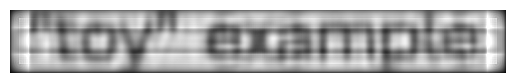

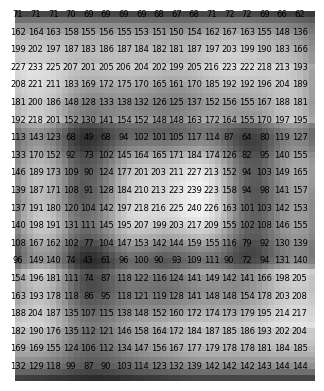

In [61]:
c = my_gc_reg_toeplitz(b,psf,10,reg,tolerance)
plt.imshow(c, cmap='gray', vmin=0, vmax=255)
plt.axis('off')
plt.show()

d = c[:,362:413]
plt.imshow(d, cmap='gray', vmin=0, vmax=255)
plt.axis('off')
height, width = d.shape
for y in range(0, height, 3):
    for x in range(0, width, 3):
        plt.text(x, y, str(d[y, x]), color='black', fontsize=6, ha='center', va='center')

plt.show()

Visualisation of the restored image after 15 steps.

Elapsed time: 6.2814552783966064 seconds
Channel 1, step=1, residual=0.2493073095703064
Elapsed time: 6.4193055629730225 seconds
Channel 1, step=2, residual=0.13701542824805574
Elapsed time: 6.418886423110962 seconds
Channel 1, step=3, residual=0.16295689865285792
Elapsed time: 6.433104038238525 seconds
Channel 1, step=4, residual=0.07428289943852362
Elapsed time: 6.380067825317383 seconds
Channel 1, step=5, residual=0.048973927710447
Elapsed time: 6.666780233383179 seconds
Channel 1, step=6, residual=0.03590935512026957
Elapsed time: 6.703350305557251 seconds
Channel 1, step=7, residual=0.029282408018812402
Elapsed time: 6.515880584716797 seconds
Channel 1, step=8, residual=0.028969909441277072
Elapsed time: 6.4851157665252686 seconds
Channel 1, step=9, residual=0.022876528506972436
Elapsed time: 6.485933303833008 seconds
Channel 1, step=10, residual=0.018110099810243006
Elapsed time: 6.5786120891571045 seconds
Channel 1, step=11, residual=0.011995909694395299
Elapsed time: 6.64996075

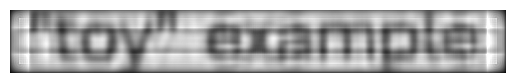

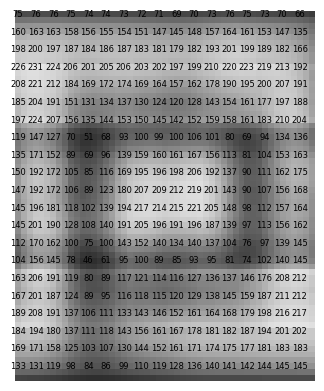

In [62]:
c = my_gc_reg_toeplitz(b,psf,15,reg,tolerance)
plt.imshow(c, cmap='gray', vmin=0, vmax=255)
plt.axis('off')
plt.show()

d = c[:,362:413]
plt.imshow(d, cmap='gray', vmin=0, vmax=255)
plt.axis('off')
height, width = d.shape
for y in range(0, height, 3):
    for x in range(0, width, 3):
        plt.text(x, y, str(d[y, x]), color='black', fontsize=6, ha='center', va='center')

plt.show()

Visualisation of the restored image after 20 steps.

Elapsed time: 6.274929761886597 seconds
Channel 1, step=1, residual=0.2493073095703064
Elapsed time: 6.429851531982422 seconds
Channel 1, step=2, residual=0.13701542824805574
Elapsed time: 6.530119895935059 seconds
Channel 1, step=3, residual=0.16295689865285792
Elapsed time: 6.52107310295105 seconds
Channel 1, step=4, residual=0.07428289943852362
Elapsed time: 6.4797141551971436 seconds
Channel 1, step=5, residual=0.048973927710447
Elapsed time: 6.962047100067139 seconds
Channel 1, step=6, residual=0.03590935512026957
Elapsed time: 6.62082576751709 seconds
Channel 1, step=7, residual=0.029282408018812402
Elapsed time: 6.487894296646118 seconds
Channel 1, step=8, residual=0.028969909441277072
Elapsed time: 6.5704734325408936 seconds
Channel 1, step=9, residual=0.022876528506972436
Elapsed time: 6.462952136993408 seconds
Channel 1, step=10, residual=0.018110099810243006
Elapsed time: 6.619062423706055 seconds
Channel 1, step=11, residual=0.011995909694395299
Elapsed time: 6.461389541625

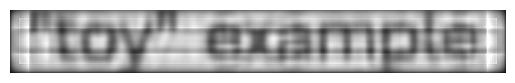

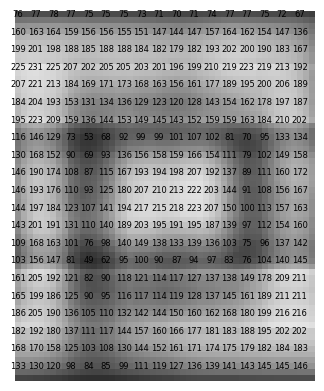

In [63]:
c = my_gc_reg_toeplitz(b,psf,20,reg,tolerance)
plt.imshow(c, cmap='gray', vmin=0, vmax=255)
plt.axis('off')
plt.show()

d = c[:,362:413]
plt.imshow(d, cmap='gray', vmin=0, vmax=255)
plt.axis('off')
height, width = d.shape
for y in range(0, height, 3):
    for x in range(0, width, 3):
        plt.text(x, y, str(d[y, x]), color='black', fontsize=6, ha='center', va='center')

plt.show()

Here is a refined version of the Cooley-Tukey FFT algorithm. The first refinement involves implementing Rader's algorithm, which handles prime-sized vectors more efficiently than the previous implementation.

Before proposing an implementation, some auxiliary functions are required. Rader's algorithm utilizes group theory to compute the FFT of a prime-sized vector. Specifically, it is necessary to compute the primitive root modulo a prime. Additionally, two other functions are needed: one for computing cyclic convolution and another for permuting the elements of a vector.

In [71]:
def find_primitive_root(p):
    """Finds a primitive root modulo p."""
    if p == 2:
        return 1
    phi = p - 1
    factors = prime_factors(phi)
    for g in range(2, p):
        if all(pow(g, phi // factor, p) != 1 for factor in factors):
            return g
    raise ValueError(f"No primitive root found for {p}")


def cyclic_convolution(a, b):
    """Performs cyclic convolution using FFT."""
    A = fft1d(a)
    B = fft1d(b)
    C = A * B
    return ifft1d(C)


def apply_permutation(vector, permutation):
    """Applies a permutation to the indices of a vector."""
    
    permuted_vector = vector.copy()
    
    for i in range(1,len(permutation)):
       
        permuted_vector[permutation[i]] = vector[permutation[i-1]]
    
    permuted_vector[permutation[0]] = vector[permutation[-1]]
    
    return permuted_vector

Below there is an implementation of the Rader's algorithm. The implementation reduces the computation of the FFT of a prime-sized vector to the computation of a convolution between two vectors of size $n-1$, where $n$ is the size of the original vector. After defining $a$ and $b$ as
$$
a_q  = x[g^q] 
$$
$$
b_q  = e^{-\frac{2\pi i}{n} g^{-q}} = \omega_n^{g^{-q}},
$$
where $g$ is a primitive root and $p$ ranges between $0$ and $n-1$, the formula
$$
X[g^{-p}]=x[0]+\sum_{q=0}^{n-2}x[g^q]\omega_n^{g^{p-q}}
$$
gives the convolution between $a$ and $b$. Finally, the first element of the output vector is obtained by
$$
X[0] = \sum_{k=0}^{n-1}x[k].
$$

In [72]:
def rader_fft(x):
    """Computes the FFT of x using Rader's algorithm."""
    N = len(x)
    assert is_prime(N), "Length of the input sequence must be a prime number."

    # Find a primitive root modulo N
    g = find_primitive_root(N)

    # Compute X_0
    X_0 = np.sum(x)

    # Compute a_q and b_q
    a = np.zeros(N-1, dtype=complex)
    b = np.zeros(N-1, dtype=complex)

    for q in range(N-1):
        a[q] = x[pow(g, q, N)]
        b[q] = np.exp(-2j * np.pi * pow(g, -q, N) / N)

    # Perform cyclic convolution using FFT
    conv_result = cyclic_convolution(a, b)

    # Prepare the DFT result
    X = np.zeros(N, dtype=complex)
    X[0] = X_0

    for p in range(1, N):
        X[pow(g, -p, N)] = x[0] + conv_result[p-1]
        
    indeces = np.zeros(N-1,dtype=int)
        
    for p in range(N-1):
        indeces[p] = pow(g, p, N)
    
    return apply_permutation(X, indeces)

To enhance cache efficiency, it is necessary to include an algorithm that computes the Fourier transform locally. One solution is to implement the direct computation of the DFT, which involves applying the definition itself.

In [73]:
def dft(x):
    """Computes the Discrete Fourier Transform (DFT) of a vector x."""
    N = len(x)
    x = np.asarray(x, dtype=complex)
    
    # Precompute the twiddle factors
    n = np.arange(N)
    k = n.reshape((N, 1))
    twiddle_factors = np.exp(-2j * np.pi * k * n / N)
    
    # Perform the matrix multiplication to get the DFT
    X = np.dot(twiddle_factors, x)
    
    return X

The following is the refined version of the FFT, which combines the Cooley-Tukey FFT, Rader's FFT, and locality techniques.

In [74]:
def fft1d(x):
    """Mixed-radix Cooley-Tukey FFT with optimizations"""
    N = len(x)
    if N <= 1:
        return x
    
    # If N is "small", compute the naive DFT to optimize cache space
    if N <= 60:
        return dft(x)
    
    if is_prime(N):
        return rader_fft(x)

    # If N is not prime, find the smallest factor to split the array
    p, q = next_factor(N)
    
    # FFT of subarrays
    X_p = [fft1d(x[k::p]) for k in range(p)]
    
    # Precompute twiddle factors
    twiddle_factors = np.exp(-2j * np.pi * np.arange(N) / N)
    
    # Combine the results using in-place computation
    X = np.zeros(N, dtype=complex) 
    for k in range(N):
        for j in range(p):
            X[k] += X_p[j][k % q] * twiddle_factors[j * k % N]
    
    return X


def ifft1d(X): return np.conj(fft1d(np.conj(X)))/len(X)

def fft2d(matrix):
    # Compute the 2D FFT using row-column decomposition
    # Apply 1D FFT to each row
    rows = np.array([fft1d(row) for row in matrix])
    
    # Apply 1D FFT to each column of the row-transformed matrix
    cols = np.array([fft1d(rows[:, j]) for j in range(rows.shape[1])]).T
    
    return cols


def ifft2d(matrix):
    # Compute the 2D IFFT using row-column decomposition
    # Apply 1D IFFT to each row
    rows = np.array([ifft1d(row) for row in matrix])
    
    # Apply 1D IFFT to each column of the row-transformed matrix
    cols = np.array([ifft1d(rows[:, j]) for j in range(rows.shape[1])]).T
    
    return cols

To compare the two versions of the algorithm, the same toy example is used.

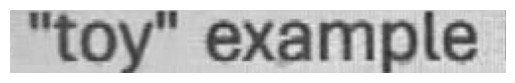

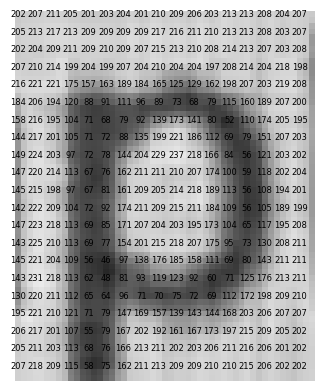

In [75]:
# Set blurring parameters
k = 9
alpha = 0.9
psf = psf_sinc(k,alpha)
reg = 0.001
tolerance = 0

# FILE PATH ON YOUR DEVICE FOR THE TOY EXAMPLE
file_path = 'toy_example.png'
# Sharp image
A = np.array(Image.open(file_path))

a = A[:,362:413,0]
plt.imshow(A)
plt.axis('off')
plt.show()
plt.imshow(a, cmap='gray', vmin=0, vmax=255)
plt.axis('off')
height, width = a.shape
for y in range(0, height, 3):
    for x in range(0, width, 3):
        plt.text(x, y, str(a[y, x]), color='black', fontsize=6, ha='center', va='center')

plt.show()

Visualisation of the blurred image.

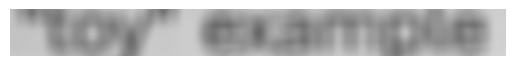

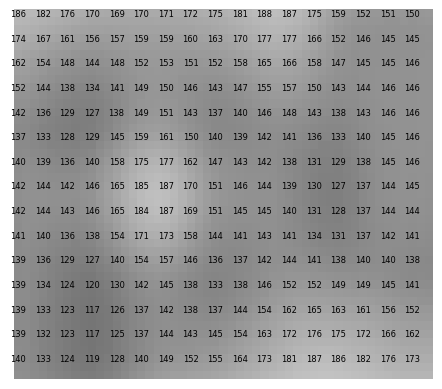

In [78]:
# Blurred image
b = blur(A[:,:,0],psf,k)
plt.imshow(b, cmap='gray', vmin=0, vmax=255)
plt.axis('off')
plt.show()
b1 = b[:,362:413]
plt.imshow(b1, cmap='gray', vmin=0, vmax=255)
plt.axis('off')
height, width = b1.shape
for y in range(0, height, 3):
    for x in range(0, width, 3):
        plt.text(x, y, str(b1[y, x]), color='black', fontsize=6, ha='center', va='center')

plt.show()

Visualisation of the restored image after 5 steps.

Elapsed time: 3.0627753734588623 seconds
Channel 1, step=1, residual=0.25202930153031533
Elapsed time: 3.1170263290405273 seconds
Channel 1, step=2, residual=0.1426549649388602
Elapsed time: 3.134974241256714 seconds
Channel 1, step=3, residual=0.18107721649989672
Elapsed time: 3.2839999198913574 seconds
Channel 1, step=4, residual=0.08991456801634708
Elapsed time: 3.281450033187866 seconds
Channel 1, step=5, residual=0.061571064081174666
Mean time per cycle: 3.1760451793670654 seconds


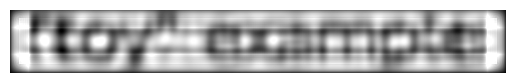

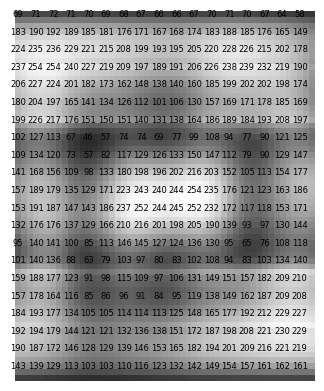

In [79]:
# Restored images
c = my_gc_reg_toeplitz(b,psf,5,reg,tolerance)
plt.imshow(c, cmap='gray', vmin=0, vmax=255)
plt.axis('off')
plt.show()

d = c[:,362:413]
plt.imshow(d, cmap='gray', vmin=0, vmax=255)
plt.axis('off')
height, width = d.shape
for y in range(0, height, 3):
    for x in range(0, width, 3):
        plt.text(x, y, str(d[y, x]), color='black', fontsize=6, ha='center', va='center')

plt.show()

Visualisation of the restored image after 10 steps.

Elapsed time: 2.788789987564087 seconds
Channel 1, step=1, residual=0.25202930153031533
Elapsed time: 2.9785149097442627 seconds
Channel 1, step=2, residual=0.1426549649388602
Elapsed time: 2.9620542526245117 seconds
Channel 1, step=3, residual=0.18107721649989672
Elapsed time: 3.4156408309936523 seconds
Channel 1, step=4, residual=0.08991456801634708
Elapsed time: 2.9847939014434814 seconds
Channel 1, step=5, residual=0.061571064081174666
Elapsed time: 2.9139578342437744 seconds
Channel 1, step=6, residual=0.048000916279580336
Elapsed time: 2.8873867988586426 seconds
Channel 1, step=7, residual=0.041549779582627525
Elapsed time: 2.839721441268921 seconds
Channel 1, step=8, residual=0.04589331222000351
Elapsed time: 2.9658145904541016 seconds
Channel 1, step=9, residual=0.040654953173582205
Elapsed time: 2.916661500930786 seconds
Channel 1, step=10, residual=0.036414016465645814
Mean time per cycle: 2.965333604812622 seconds


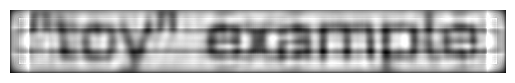

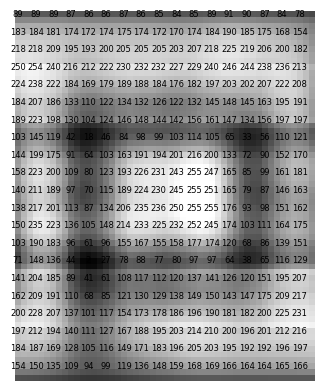

In [80]:
# Restored images
c = my_gc_reg_toeplitz(b,psf,10,reg,tolerance)
plt.imshow(c, cmap='gray', vmin=0, vmax=255)
plt.axis('off')
plt.show()

d = c[:,362:413]
plt.imshow(d, cmap='gray', vmin=0, vmax=255)
plt.axis('off')
height, width = d.shape
for y in range(0, height, 3):
    for x in range(0, width, 3):
        plt.text(x, y, str(d[y, x]), color='black', fontsize=6, ha='center', va='center')

plt.show()

Visualisation of the restored image after 15 steps

Elapsed time: 2.9713518619537354 seconds
Channel 1, step=1, residual=0.25202930153031533
Elapsed time: 3.1670591831207275 seconds
Channel 1, step=2, residual=0.1426549649388602
Elapsed time: 3.0667569637298584 seconds
Channel 1, step=3, residual=0.18107721649989672
Elapsed time: 3.233372211456299 seconds
Channel 1, step=4, residual=0.08991456801634708
Elapsed time: 3.2503530979156494 seconds
Channel 1, step=5, residual=0.061571064081174666
Elapsed time: 3.250441312789917 seconds
Channel 1, step=6, residual=0.048000916279580336
Elapsed time: 3.318620204925537 seconds
Channel 1, step=7, residual=0.041549779582627525
Elapsed time: 3.2980358600616455 seconds
Channel 1, step=8, residual=0.04589331222000351
Elapsed time: 3.4006364345550537 seconds
Channel 1, step=9, residual=0.040654953173582205
Elapsed time: 3.2977030277252197 seconds
Channel 1, step=10, residual=0.036414016465645814
Elapsed time: 3.396873950958252 seconds
Channel 1, step=11, residual=0.026819988937882105
Elapsed time: 3.31

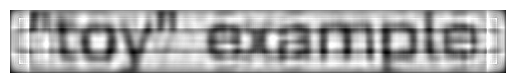

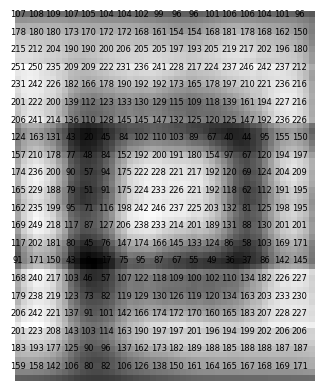

In [81]:
# Restored images
c = my_gc_reg_toeplitz(b,psf,15,reg,tolerance)
plt.imshow(c, cmap='gray', vmin=0, vmax=255)
plt.axis('off')
plt.show()

d = c[:,362:413]
plt.imshow(d, cmap='gray', vmin=0, vmax=255)
plt.axis('off')
height, width = d.shape
for y in range(0, height, 3):
    for x in range(0, width, 3):
        plt.text(x, y, str(d[y, x]), color='black', fontsize=6, ha='center', va='center')

plt.show()

Visualisation of the restored image after 20 steps.

Elapsed time: 2.983334541320801 seconds
Channel 1, step=1, residual=0.25202930153031533
Elapsed time: 3.220637798309326 seconds
Channel 1, step=2, residual=0.1426549649388602
Elapsed time: 3.1212947368621826 seconds
Channel 1, step=3, residual=0.18107721649989672
Elapsed time: 3.261979341506958 seconds
Channel 1, step=4, residual=0.08991456801634708
Elapsed time: 3.4484121799468994 seconds
Channel 1, step=5, residual=0.061571064081174666
Elapsed time: 3.366211175918579 seconds
Channel 1, step=6, residual=0.048000916279580336
Elapsed time: 3.3283543586730957 seconds
Channel 1, step=7, residual=0.041549779582627525
Elapsed time: 3.2532706260681152 seconds
Channel 1, step=8, residual=0.04589331222000351
Elapsed time: 3.3867573738098145 seconds
Channel 1, step=9, residual=0.040654953173582205
Elapsed time: 3.32616925239563 seconds
Channel 1, step=10, residual=0.036414016465645814
Elapsed time: 3.4201557636260986 seconds
Channel 1, step=11, residual=0.026819988937882105
Elapsed time: 3.3069

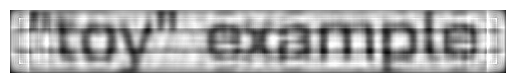

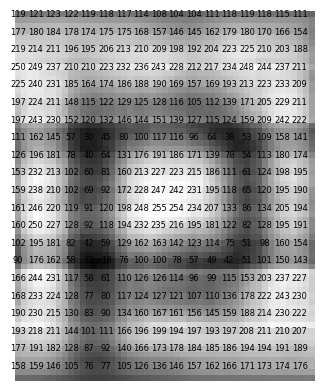

In [82]:
# Restored images
c = my_gc_reg_toeplitz(b,psf,20,reg,tolerance)
plt.imshow(c, cmap='gray', vmin=0, vmax=255)
plt.axis('off')
plt.show()

d = c[:,362:413]
plt.imshow(d, cmap='gray', vmin=0, vmax=255)
plt.axis('off')
height, width = d.shape
for y in range(0, height, 3):
    for x in range(0, width, 3):
        plt.text(x, y, str(d[y, x]), color='black', fontsize=6, ha='center', va='center')

plt.show()

The code provided so far is suitable for small images, as the FFT implementation struggles with larger sizes. Therefore, the code below applies the same concepts using NumPy's built-in functions for 2D FFT, which can handle much larger images.

In [86]:
def fftpsf(psf, m, n):
    """
    Pad the PSF to the same size of a restored image. 
    Calculate the FFT of this zero-padded PSF matrix.
    """
    s = psf.shape
    a = np.zeros((m + s[0] - 1, n + s[1] - 1), dtype=psf.dtype)
    a[:s[0], :s[1]] = psf
    fpsf = np.fft.fft2(a)
    return fpsf


def fx(fpsf, x):
    """
    Compute the product y=Fx of the block-Toeplitz matrix F and a vector x.
    """
    m, n = fpsf.shape
    sx = x.shape
    xx = np.zeros((m, n), dtype=x.dtype)
    xx[:sx[0], :sx[1]] = x
    fx = np.fft.fft2(xx)
    y = np.fft.ifft2(fx * fpsf)
    return y


def ftx(fpsf, w, k):
    """
    Compute the product z = F^Ty of the transpose of the block-Toeplitz matrix F^T
    and a vector y.
    """
    fw = np.fft.fft2(w)
    u = np.fft.ifft2(fw * np.conj(fpsf))
    z = u[:-(2*k), :-(2*k)]  # Extracting the desired region
    return z


def gc_reg_toeplitz(b, psf, steps, reg, epsilon):
    times = np.zeros(steps)
    # Define the point-spread function (psf)
    psft = psf[::-1, ::-1]
    z = psft.shape
    k = int((z[0] - 1)/2) # k is an integer    
    
    # Define the dimensions of the objects
    s = b.shape
    
    # Initialize the iterations of GC
    if len(s) == 3:
        x = np.zeros((s[0]+2*k,s[1]+2*k,s[2]))
        coln = 3
    else:
        x = np.zeros((s[0]+2*k,s[1]+2*k))
        coln = 1
    
    # psf associated to F^T
    psft = fftpsf(psf,s[0],s[1])
    for col in range(coln):
        if coln == 3:
            r = b[:, :, col]
        else:
            r = b
        
        r = np.double(r)
        y = np.zeros((s[0], s[1]))
        for iter in range(steps):
            start_time = time.time()
            rho = np.sum(np.sum(r * r))
            if iter == 0:
                p = r
            else:
                beta = rho / rhop
                p = r + beta * p
            
            tmp = fx(psft,p)
            q = ftx(psft,tmp,k)
            q = q + reg * p
            alpha = rho / np.sum(np.sum(p * q))
            y = y + alpha * p
            r = r - alpha * q
            rhop = rho
            nor = np.abs(np.sqrt(np.sum(np.sum(r * r))) / (s[0] * s[1]))
            end_time = time.time()
            elapsed_time = end_time - start_time
            times[iter] = elapsed_time
            print("Elapsed time:", elapsed_time, "seconds")
            print(f'Channel {col+1}, step={iter+1}, residual={nor}')
        
            # Check convergence
            if nor < epsilon:
                print(f'Converged at step {iter+1} with residual {nor}')
                break
        
        if coln == 3:
            x[:, :, col] = np.real(fx(psft,y))
        else:
            x = np.real(fx(psft,y))
        
    x = np.clip(x,0,255).astype(np.uint8)
    print("Mean time per cycle:", np.mean(times), "seconds")
    
    return x


The following is an application of this version to a realistic image, which has been blurred using a sinc PSF with parameters $\alpha=0.04$ and $k=4$.

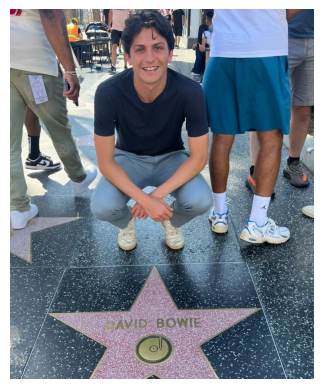

Elapsed time: 0.520707368850708 seconds
Channel 1, step=1, residual=0.00796483683042387
Elapsed time: 0.5918765068054199 seconds
Channel 1, step=2, residual=0.005336794762803282
Elapsed time: 0.4963071346282959 seconds
Channel 1, step=3, residual=0.003989030349138592
Elapsed time: 0.6000211238861084 seconds
Channel 1, step=4, residual=0.003131004132382624
Elapsed time: 0.4867706298828125 seconds
Channel 1, step=5, residual=0.0025723857013256247
Elapsed time: 0.48043322563171387 seconds
Channel 1, step=6, residual=0.002087029177412148
Elapsed time: 0.48677968978881836 seconds
Channel 1, step=7, residual=0.0016847285642388392
Elapsed time: 0.5132472515106201 seconds
Channel 1, step=8, residual=0.001464483567218349
Elapsed time: 0.47866010665893555 seconds
Channel 1, step=9, residual=0.0013628243819736555
Elapsed time: 0.5060434341430664 seconds
Channel 1, step=10, residual=0.0013257379535401511
Elapsed time: 0.47884678840637207 seconds
Channel 1, step=11, residual=0.001333921738513428
El

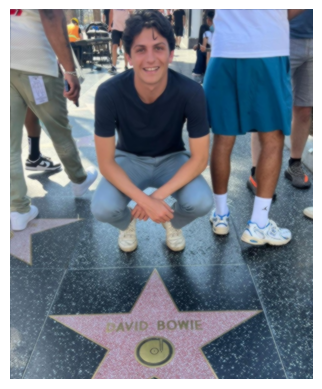

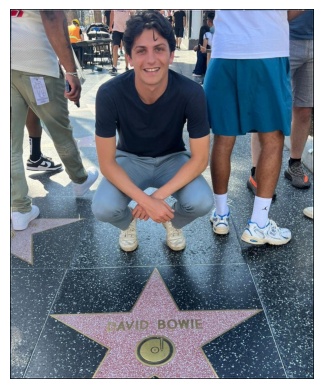

In [87]:
# Set parameters
k = 4
alpha = 0.4
psf = psf_sinc(k,alpha)
reg = 0.001
tolerance = 0

## REAL EXAMPLE
# File path of your device for the real example
file_path = 'real_example.jpg'
# Read an image
A = np.array(Image.open(file_path))
plt.imshow(A)
plt.axis('off')
plt.show()
b = blur(A,psf,k)
c = gc_reg_toeplitz(b,psf,40,reg,tolerance)
plt.imshow(b)
plt.axis('off')
plt.show()
plt.imshow(c)
plt.axis('off')
plt.show()